In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta as ta
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#

In [2]:
Base="USD"
Quote="JPY"
Pair=Base+Quote

ticker = "USDJPY=X"
#start="2021-01-01"
start=pd.to_datetime('2021-01-01', format='%Y-%m-%d')
today_date = datetime.today().strftime('%Y-%m-%d')


initial_wealth = 1

In [3]:
#Deposit Rate
#https://www.interactivebrokers.com/en/accounts/fees/pricing-interest-rates.php
USD_deposit_interest=0.0483
JPY_deposit_interest=-0.00257
EUR_deposit_interest=0.03427
GBP_deposit_interest=0.04682
AUD_deposit_interest=0.03769
NZD_deposit_interest=0.02835
CAD_deposit_interest=0.04343
CNH_deposit_interest=0.0050
SGD_deposit_interest=0.02642

#Margin Rate
#https://www.interactivebrokers.com/en/trading/margin-rates.php
USD_margin_interest=0.0683
JPY_margin_interest=0.015
EUR_margin_interest=0.05427
GBP_margin_interest=0.06682
AUD_margin_interest=0.05769
NZD_margin_interest=0.06835
CAD_margin_interest=0.06343
CNH_margin_interest=0.06234
SGD_margin_interest=0.05142

#Deposit_interest=Base+"_deposit_interest"
#Margin_interest=Quote+"_margin_interest"

#Trading Cost
Trading_cost=0.000002
#https://www.interactivebrokers.com/en/pricing/commissions-spot-currencies.php

#Used for calculating Sharpe, can also be used as hurdle rate
riskfree_rate = 0.03

In [4]:
# download daily stock price data by passing in specified ticker and date range

df = yf.download(ticker,start,end=today_date)

[*********************100%%**********************]  1 of 1 completed


In [5]:
#Change interest rates accordingly
df['returns'] = np.log(df['Close'] / df['Close'].shift(1)) +(USD_deposit_interest-JPY_margin_interest)/365.25

print(df)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-01-01  103.225998  103.250000  103.225998  103.225998  103.225998   
2021-01-04  103.244003  103.244003  102.709999  103.238998  103.238998   
2021-01-05  103.141998  103.180000  102.671997  103.125000  103.125000   
2021-01-06  102.699997  103.431000  102.589996  102.678001  102.678001   
2021-01-07  103.028000  103.950996  102.956001  103.024002  103.024002   
...                ...         ...         ...         ...         ...   
2024-05-22  156.251007  156.604996  156.147003  156.251007  156.251007   
2024-05-23  156.703995  157.162994  156.529007  156.703995  156.703995   
2024-05-24  156.973007  157.136993  156.867996  156.973007  156.973007   
2024-05-27  156.869995  156.955002  156.677994  156.869995  156.869995   
2024-05-28  156.845001  156.988998  156.612000  156.845001  156.845001   

            Volume   returns  
Date  

In [11]:
def ma_strat(df,window1,window2):
    #read in data from Yahoo Finance for the relevant ticker
    df['short_ma'] = np.round(df['Close'].rolling(window=window1).mean(),4)
    df['long_ma'] = np.round(df['Close'].rolling(window=window2).mean(),4)
     
    #create column with moving average spread differential
    df['short_ma-long_ma'] = df['short_ma'] - df['long_ma']
    
    #set desired number of points as threshold for spread difference and create column containing strategy 'Stance'
    X = 0
    df['Stance'] = np.where(df['short_ma-long_ma'] > X, 1, 0)
    df['Stance'] = np.where(df['short_ma-long_ma'] < -X, -1, df['Stance'])
    df['Stance'].value_counts()
     
    #create columns containing daily market log returns and strategy daily log returns
    df['Market Returns'] = np.log(df['Close'] / df['Close'].shift(1)) +(USD_deposit_interest-JPY_margin_interest)/365.25
    df['Strategy'] = df['Market Returns'] * df['Stance'].shift(1)
     
    #set strategy starting equity to 1 (i.e. 100%) and generate equity curve
    df['Strategy Equity'] = df['Strategy'].cumsum() + 1
     
    sharpe = annualised_sharpe(df['Strategy'])
    
    return (df['Strategy'].cumsum()[-1], sharpe)

#function to calculate Sharpe Ratio - Risk free rate element excluded for simplicity
def annualised_sharpe(returns, N=252):
    return np.sqrt(N) * (returns.mean() / returns.std())

In [12]:
window1 = np.linspace(10,30,20,dtype=int)
window2 = np.linspace(40,60,20,dtype=int)

results_pnl = np.zeros((len(window1),len(window2)))
results_sharpe = np.zeros((len(window1),len(window2)))

#df['MA1'] = df['Close'].rolling(window1).mean()
#df['MA2'] = df['Close'].rolling(window2).mean()

#df[['Close', 'MA1','MA2']].plot(figsize=(10, 6));

In [13]:
for i, shortma in enumerate(window1):
    for j, longma in enumerate(window2):
        pnl, sharpe = ma_strat(df,shortma,longma)
        results_pnl[i,j] = pnl
        results_sharpe[i,j] = sharpe

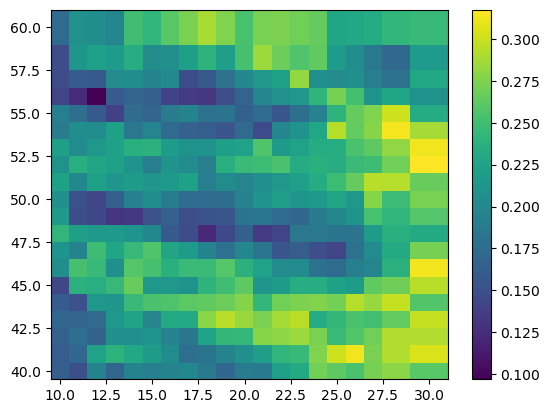

In [14]:
plt.pcolor(window1,window2,results_pnl)
plt.colorbar()
plt.show()

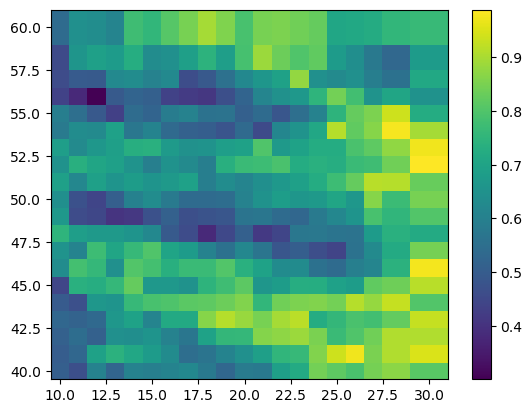

In [15]:
plt.pcolor(window1,window2,results_sharpe)
plt.colorbar()
plt.show()

In [24]:
indices = np.where(results_pnl == results_pnl.max())
print (indices)

(array([12]), array([19]))
